In [23]:
# inbuilt
from argparse import Namespace
from collections import Counter,OrderedDict
from functools import partial

# torch
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader,default_collate
from torch.utils.data.backward_compatibility import worker_init_fn
## torch others
from torchdata import datapipes as dp
from torchtext import vocab
from torchmetrics import Accuracy

# manipulation
import numpy as np

# visual
import matplotlib.pyplot as plt

# others
from tqdm import tqdm


In [2]:
args = Namespace(
    # data 
    ## flag
    use_split_data = True,
    ## path and filenames
    data_base_path = "../data/surnames/",
    data_filename = "surnames.csv",
    split_weights = {"train":0.7,"test":0.15,"val":0.15},
    
    # vocab
    ukn_tkn = "@",
    
    # training parameter
    num_epochs = 100,
    batch_size = 64,
    learning_rate = 0.001,
    early_stopping_criteria = 5,
    seed = 1424,
    
    # model
    num_channels = 256,    
    ## path and file
    model_base_path = "../models/surnames/",
    model_filename = "cnn_model.pth",
    
    # runtime options
    cuda = torch.cuda.is_available(),
    device = "cuda" if torch.cuda.is_available() else "cpu",
)

# Data pipes

## Create the datapipes

In [3]:
def create_pipes_dict(args):
    pipe_dict = {}
    for fname in args.split_weights.keys():
        pipe_dict[fname] = dp.iter.FileOpener([args.data_base_path+f"{fname}.csv"]).parse_csv()
    
    return pipe_dict

In [4]:
pipes_dict = create_pipes_dict(args)
pipes_dict

{'train': CSVParserIterDataPipe,
 'test': CSVParserIterDataPipe,
 'val': CSVParserIterDataPipe}

## Create vocab dict

In [5]:
def surname_token_fn(row):
    return row[0]

def nation_token_fn(row):
    return [row[1]]

In [6]:
def create_vocab_dict(train_pipe,args=args):
    surname_token = train_pipe.map(surname_token_fn)
    counter = Counter()
    max_length = -1
    for token in surname_token:
        max_length = max(max_length,len(token))
        counter.update(token)
    sorted_by_freq_tuples = sorted(counter.items(),key= lambda kf :(-kf[1],kf[0]))
    order_dict = OrderedDict(sorted_by_freq_tuples)
    surname_vocab = vocab.vocab(ordered_dict=order_dict,
                                specials=[args.ukn_tkn])
    surname_vocab.set_default_index(surname_vocab[args.ukn_tkn])
    surname_vocab.max_length = max_length
    
    nation_token = train_pipe.map(nation_token_fn)
    nation_vocab = vocab.build_vocab_from_iterator(nation_token)
    
    return {"surname":surname_vocab,
            "nation":nation_vocab}

In [7]:
vocab_dict = create_vocab_dict(pipes_dict["train"])

## create dataset_dict

In [8]:
def vectorize(surname,surname_vocab):
    vector = np.zeros(shape=(len(surname_vocab),surname_vocab.max_length),
                      dtype=np.float32)
    for idx,char in enumerate(surname):
        char_idx = surname_vocab.lookup_indices([char])[-1]
        vector[char_idx,idx] = 1
    
    return vector   


def create_input_output_dict(vocab_dict,row):
    surname_matrix = vectorize(row[0],vocab_dict["surname"])
    nation_idx = vocab_dict["nation"].lookup_indices([row[1]])[-1]
    return {"x":surname_matrix,
            "y":nation_idx}

In [9]:
def create_dataset_dict(pipes_dict,vocab_dict,args=args):
    dataset_dict = {}
    fn = partial(create_input_output_dict,vocab_dict)
    for key,pipe in pipes_dict.items():
        if key == "train":
            pipe = pipe.shuffle()
        pipe = pipe.map(fn)
        pipe = pipe.batch(args.batch_size,drop_last=True) 
        dataset_dict[key] = pipe
    
    return dataset_dict             

In [10]:
dataset_dict = create_dataset_dict(pipes_dict,vocab_dict)

## Generate batches

In [11]:
def collate_fn(args,x):
    return {k:v.to(args.device)
            for x_ in default_collate(x)
            for k,v in x_.items()}

In [12]:
def generate_batches(dataset,args=args,shuffle=False):
    dataloader = DataLoader(dataset=dataset,
                            batch_size=args.batch_size,
                            shuffle=shuffle,
                            worker_init_fn=worker_init_fn,
                            collate_fn=partial(collate_fn,args))
    for batch in dataloader:
        yield batch

# Model

In [19]:
class SurnameClassifier(nn.Module):
    def __init__(self,initial_num_channels,num_classes,num_channels) -> None:
        super().__init__()
        self.convnet =  nn.Sequential(
            nn.Conv1d(in_channels=initial_num_channels,
                      out_channels=num_channels,
                      kernel_size=3),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels,
                      out_channels=num_channels,
                      kernel_size=3,
                      stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels,
                      out_channels=num_channels,
                      kernel_size=3,
                      stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels,
                      out_channels=num_channels,
                      kernel_size=3),
            nn.ELU(),
        )
        self.fc = nn.Linear(num_channels,num_classes)
     
     
    def forward(self,input,apply_softmax=False):
        features = self.convnet(input).squeeze(dim=2)
        prediction_vector = self.fc(features)
        if apply_softmax:
            prediction_vector = torch.softmax(prediction_vector,dim=1)
            
        return prediction_vector

# Training 

## Helper function

In [14]:
def make_train_state(args=args):
    return {"stop_early":False,
            "early_stopping_step":0,
            "early_stopping_val":1e8,
            "learning_rate":args.learning_rate,
            "epoch_index":0,
            "model_filename":args.model_base_path+args.model_filename,
            "train_loss":[],
            "train_acc":[],
            "val_loss":[],
            "val_acc":[],
            "test_loss":-1,
            "test_acc":-1}
    
def update_train_state(train_state,model,args=args):
    if train_state["epoch_index"] == 0:
        torch.save(model.state_dict(),train_state["model_filename"])
        train_state["stop_early"] = False
        
    elif train_state["epoch_index"] >= 1:
        loss_tm1,loss_t = train_state["val_loss"][-2:]
        if loss_t >=  train_state["early_stopping_val"]:
            train_state["early_stopping_step"] += 1
        else:
            torch.save(model.state_dict(),train_state["model_filename"])
            train_state["early_stopping_step"] = 0 
            
        train_state["stop_early"] = train_state["early_stopping_step"] >= args.early_stopping_criteria
    return train_state

In [15]:
def set_seed_everywhere(seed,cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)
        
set_seed_everywhere(args.seed,args.cuda)

## initialize

In [16]:
nation_count = torch.load(args.data_base_path+"count.pth")

In [21]:
class_weights = 1.0/torch.tensor(list(nation_count.values()),dtype=torch.float32).to(args.device)
classifier = SurnameClassifier(initial_num_channels=len(vocab_dict["surname"]),
                               num_classes=len(vocab_dict["nation"]),
                               num_channels=args.num_channels).to(args.device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
acc_fn = Accuracy(task="multiclass",num_classes=len(class_weights)).to(args.device)
optimizer = optim.Adam(params=classifier.parameters(),
                       lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode="min",factor=0.5,
                                                 patience=1)
train_state = make_train_state(args)

## Train loop

In [22]:
for epoch_index in tqdm(range(args.num_epochs)):
    train_state["epoch_index"] = epoch_index
    
    # init the running variable
    running_loss = 0.0
    running_acc = 0.0
    
    # get the train dataloader
    batch_generator = generate_batches(dataset=dataset_dict["train"],
                                       args=args,shuffle=True)
    
    # put the model in training mode
    classifier.train()
    
    for batch_idx,batch_dict in enumerate(batch_generator):
        optimizer.zero_grad()
        logits = classifier(batch_dict["x"])
        # compute the loss per batch
        loss = loss_fn(logits,batch_dict["y"])
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_idx+1)
        
        # compute the acc per batch
        acc = acc_fn(logits,batch_dict["y"])
        acc_t = acc.item()
        running_acc += (acc_t - running_acc) / (batch_idx+1)
        
        loss.backward()
        
        optimizer.step()
        
    train_state["train_loss"].append(running_loss)
    train_state["train_acc"].append(running_acc)
    
    # iterate over the val dataset
    
    # init the running variable
    running_loss = 0.0
    running_acc = 0.0
    
    # get the val dataloader
    batch_generator  = generate_batches(dataset=dataset_dict["val"],
                                        args=args,shuffle=False)
    
    # put the model in eval mode
    classifier.eval()
    
    for batch_idx,batch_dict in enumerate(batch_generator):
        with torch.inference_mode():
            logits = classifier(batch_dict["x"])
            
            # compute the loss
            loss = loss_fn(logits,batch_dict["y"])
            loss_t = loss.item()
            running_loss += (loss_t-running_loss) /(batch_idx+1)
            
            # compute the acc
            acc = acc_fn(logits,batch_dict["y"])
            acc_t = acc.item()
            running_acc += (acc_t-running_acc) /(batch_idx+1)
            
    train_state["val_loss"].append(running_loss)
    train_state["val_acc"].append(running_acc)
    
    
    train_state = update_train_state(train_state=train_state,
                                     model=classifier,
                                     args=args)
    
    scheduler.step(train_state["val_loss"][-1])
    if train_state["stop_early"]:
        break          

100%|██████████| 100/100 [01:40<00:00,  1.00s/it]


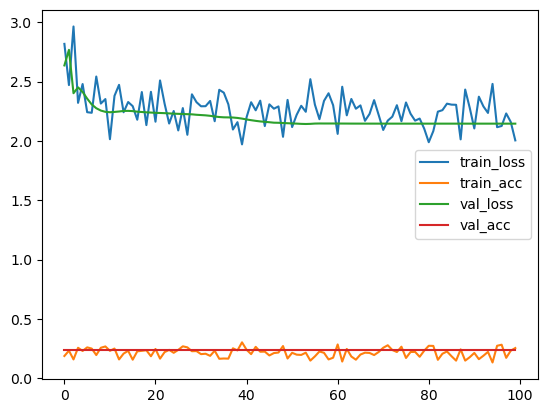

In [25]:
plt.plot(train_state["train_loss"],label="train_loss")
plt.plot(train_state["train_acc"],label="train_acc")
plt.plot(train_state["val_loss"],label="val_loss")
plt.plot(train_state["val_acc"],label="val_acc")
plt.legend();

In [24]:
batch_generator = generate_batches(dataset=dataset_dict["test"],
                                   args=args,shuffle=False)

running_acc = 0.0
running_loss = 0.0
classifier.eval()

for batch_idx,batch_dict in enumerate(batch_generator):
    with torch.inference_mode():
        logits = classifier(batch_dict["x"])
        
        # compute the loss
        loss = loss_fn(logits,batch_dict["y"])
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) /(batch_idx+1)
        
        # compute the acc
        acc = acc_fn(logits,batch_dict["y"])
        acc_t = acc.item()
        running_acc += (acc_t - running_acc) / (batch_idx+1)
        
train_state["test_loss"] = running_loss
train_state["test_acc"] = running_acc

In [26]:
print(f"Test Loss : {train_state['test_loss']}")
print(f"Test Acc : {train_state['test_acc']:.2%}")

Test Loss : 2.2003955841064453
Test Acc : 24.00%
